In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Generate data

In [2]:
from read_results import read_varnames
import small_strato_f90.kpp4py as kpp4py

In [3]:
nvar = 5
varnames = read_varnames("small_strato_F90/small_strato_Parameters.f90")[0:nvar]
print(varnames)

['O1D', 'O', 'O3', 'NO', 'NO2']


In [4]:
df_range = (
    pd.read_csv('small_strato_range.csv', index_col=0)
    .append(pd.DataFrame(np.array([[0.0, 1.0]]), 
                         columns=['min','max'], 
                         index=['SUN']
                        )
           )
)

df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range['span'] = df_range['max'] - df_range['min']
df_range.tail(10)

,min,max,mid,span
O1D,1.000000e-08,1.550810e+02,7.754051e+01,1.550810e+02
O,1.000000e-08,1.040641e+09,5.203203e+08,1.040641e+09
O3,5.377002e+11,8.486620e+11,6.931811e+11,3.109618e+11
NO,1.000000e-08,9.433271e+08,4.716635e+08,9.433271e+08
NO2,1.531729e+08,1.096500e+09,6.248365e+08,9.433271e+08
SUN,0.000000e+00,1.000000e+00,5.000000e-01,1.000000e+00


In [5]:
shrink = 0.0

y0_list =  np.random.uniform(df_range['min'] + shrink*df_range['span'],
                             df_range['max'] - shrink*df_range['span'], 
                             size=(5000, nvar+1))
y0_list.shape

(5000, 6)

In [6]:
%time y1_list = kpp4py.onestep(y0_list.T).T
y1_list.shape

CPU times: user 115 ms, sys: 2.57 ms, total: 117 ms
Wall time: 129 ms


(5000, 5)

# Normalize data

In [7]:
normalizer = StandardScaler()
normalizer.fit(y0_list[:,0:5])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
X_train = np.append(normalizer.transform(y0_list[:,0:5]), 
                    y0_list[:,-1:], 
                    axis=1)
X_train.shape

(5000, 6)

In [9]:
Y_train = normalizer.transform(y1_list)
Y_train.std(axis=0)

array([0.86993756, 0.85154739, 0.99375973, 1.26000523, 1.01489038])

# Examine data

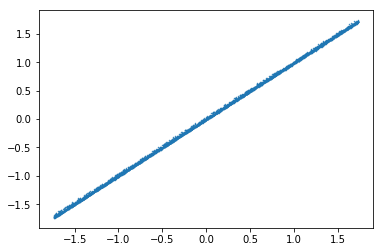

In [10]:
plt.scatter(X_train[:,2], Y_train[:,2], s=0.2)

# Fit ANN

In [11]:
x_torch = Variable(torch.from_numpy(X_train))
y_torch = Variable(torch.from_numpy(Y_train))

In [12]:
H1, H2 = 10, 10

model = torch.nn.Sequential(
    torch.nn.Linear(6, H1),
    #torch.nn.ReLU(),
    torch.nn.Tanh(),
    torch.nn.Linear(H1, H2),
    #torch.nn.ReLU(),
    torch.nn.Tanh(),
    torch.nn.Linear(H2, 5)
).double()

In [13]:
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

for t in range(200):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%20==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.data[0])

20 0.002523665809463781
40 0.00031761804991400536
60 0.00015554601850845142
80 9.908886528749279e-05
100 7.724437359305696e-05
120 6.166298077654274e-05
140 5.1986830861990265e-05
160 4.4428022382965106e-05
180 3.987110866258921e-05
200 3.985216674343694e-05


In [14]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.data.numpy()

CPU times: user 2.75 ms, sys: 1.48 ms, total: 4.23 ms
Wall time: 2.45 ms


In [15]:
y_pred_numpy.shape

(5000, 5)

In [16]:
r2_score(y_pred_numpy, Y_train)

0.9999600501022534

# Test set

In [17]:
shrink = 0.0

y0_test =  np.random.uniform(df_range['min'] + shrink*df_range['span'],
                             df_range['max'] - shrink*df_range['span'], 
                             size=(20000, nvar+1))

In [18]:
%time y1_test = kpp4py.onestep(y0_test.T).T

CPU times: user 652 ms, sys: 13.4 ms, total: 666 ms
Wall time: 443 ms


In [19]:
X_test = np.append(normalizer.transform(y0_test[:,0:5]), 
                   y0_test[:,-1:], 
                   axis=1)
Y_test = normalizer.transform(y1_test)

In [20]:
Y_test.shape

(20000, 5)

In [21]:
%%time
X_torch_test = Variable(torch.from_numpy(X_test))
y_test_pred = model(X_torch_test).data.numpy()

CPU times: user 16.2 ms, sys: 3.31 ms, total: 19.5 ms
Wall time: 11.9 ms


In [22]:
r2_score(y_test_pred, Y_test)

0.9999588437365474

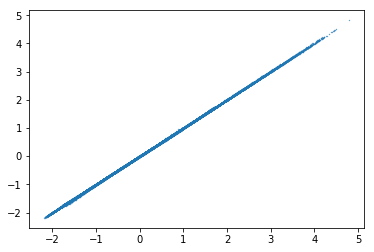

In [23]:
plt.scatter(y_test_pred, Y_test, s=0.1)

# Use Plotly interactive plot

In [24]:
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

In [25]:
init_notebook_mode(connected=True)

In [26]:
def get_trace(i):
    trace = go.Scattergl(
        x = Y_test[:,i],
        y = y_test_pred[:,i],
        mode = 'markers',
        name = varnames[i],
        marker = go.Marker(size=5, opacity=0.5)
    )
    return trace

data = [get_trace(i) for i in range(5)]

In [ ]:
layout = go.Layout(width=600, height=400)
fig = go.Figure(data=data, layout=layout)
iplot(fig)